# Mid-Term Project — Night-Time Image Enhancement

# Goal: 
Given a pair of images of the same scene—one captured at night and the other at day—design and implement your best method to enhance the night-time image so that it matches the day-time appearance as closely as possible.

### Primary evaluation metric:
Mean Squared Error (MSE) between your enhanced image and the day-time image.

### Performance matters: 
Your grade will be impacted by quantitative performance (MSE), alongside method quality and reproducibility.



# MSE
Mean Squared Error (MSE) measures the average squared difference between corresponding pixels of two images. If your enhanced image is compared to a reference day-time image, the formula for MSE is:
<center>

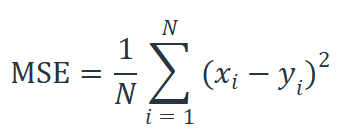

</center>

where:

•   xi = pixel value in the enhanced image

•   yi = pixel value in the day-time image

•   N = total number of pixels (or pixel values)


# Channel-wise MSE
Images typically have 3 color channels: Red (R), Green (G), and Blue (B). Instead of computing one MSE over all channels combined, channel-wise MSE computes MSE separately for each channel:
<center>

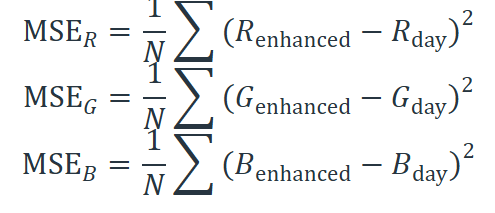
</center>

Then you can average them as the final difference:
<center>

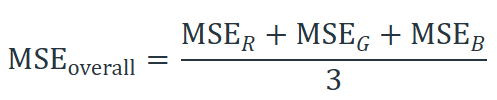
</center>

Please report this number in your report and slides.​

# Important Note on Method Choice
Students are allowed to use any method to achieve the goal—classical, learning-based, or hybrid approaches.
If your chosen method requires training or fine-tuning, you must prepare the training data yourself. The provided image pair is not sufficient for robust training, so you are expected to design or collect additional data (e.g., augmentations, synthetic generation, or external datasets) as needed.

Ensure that your pipeline remains generalizable and does not overfit to the single provided pair.

# Dataset
•  You are provided with one pair of images of the same scene (please check the files in Files/Mid-Term/):

     •  night.png (or .jpg): Night-time capture.

     •  day.png (or .jpg): Day-time capture (the reference/target).

•  Both images may differ in exposure, noise, white balance, and viewpoint (small shifts).

•  Optional: If we release additional hidden pairs, your method will be re-run on those for final grading. Design your pipeline to be robust and not overfit to a single visible pair.

Important constraint (integrity rule): During inference, your pipeline must use only the night-time image. The day-time image can be used for training/supervision, parameter selection, or histogram matching, but it must not be directly copied or blended at test time.

# Academic Integrity & Collaboration
•  You may discuss high-level ideas, but all code must be your own or clearly credited (for any third-party snippets/models).

•  Cite all sources and pretrained models.

•  Clearly mark any borrowed components in the report and code headers.

In [1]:
import cv2
import numpy as np

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

In [2]:
def gray_world_white_balance(img):
    avg = np.mean(img, axis=(0,1))
    scale = np.mean(avg) / (avg + 1e-6)
    return np.clip(img * scale, 0, 1)

In [3]:
def denoise(img):
    img_8 = (img * 255).astype(np.uint8)
    denoised = cv2.fastNlMeansDenoisingColored(
        img_8, None,
        h=10, hColor=10,
        templateWindowSize=7,
        searchWindowSize=21
    )
    return denoised.astype(np.float32) / 255.0

In [4]:
def multi_scale_retinex(img, scales=(15, 80, 250)):
    retinex = np.zeros_like(img)
    for sigma in scales:
        blur = cv2.GaussianBlur(img, (0,0), sigma)
        retinex += np.log(img + 1e-6) - np.log(blur + 1e-6)
    retinex /= len(scales)
    return retinex

In [5]:
def normalize(img):
    img = img - img.min()
    img = img / (img.max() + 1e-6)
    return img

In [6]:
def enhance_contrast(img):
    img_8 = (img * 255).astype(np.uint8)
    lab = cv2.cvtColor(img_8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(
        clipLimit=2.0,
        tileGridSize=(max(4, img.shape[1]//128),
                      max(4, img.shape[0]//128))
    )

    l = clahe.apply(l)
    lab = cv2.merge((l,a,b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)/255.0

In [7]:
def exposure_adjust(img, gain=1.2, gamma=0.9):
    img = img * gain
    img = np.power(np.clip(img, 0, 1), gamma)
    return img

In [8]:
def tone_map(img, strength=0.6):
    return img / (img + strength)

In [9]:
def denoise_luminance(img):
    lab = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    l = cv2.fastNlMeansDenoising(
        l, None, h=7, templateWindowSize=7, searchWindowSize=21
    )

    lab = cv2.merge((l,a,b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)/255.0

In [10]:
def detail_recover(img):
    smooth = cv2.GaussianBlur(img, (0,0), 1.5)
    detail = img - smooth
    return np.clip(img + 0.3 * detail, 0, 1)

In [11]:
def color_transfer(source, target):
    """
    source: predicted image
    target: real day reference image
    """
    src_lab = cv2.cvtColor((source*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    tgt_lab = cv2.cvtColor((target*255).astype(np.uint8), cv2.COLOR_RGB2LAB)

    src_mean, src_std = cv2.meanStdDev(src_lab)
    tgt_mean, tgt_std = cv2.meanStdDev(tgt_lab)

    out = (src_lab - src_mean) * (tgt_std / (src_std + 1e-6)) + tgt_mean
    out = np.clip(out, 0, 255).astype(np.uint8)

    return cv2.cvtColor(out, cv2.COLOR_LAB2RGB).astype(np.float32)/255.0

In [12]:
def daylight_color_adapt(img, target_temp=6500):
    # Simple chromatic adaptation toward daylight
    img_lab = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)

    a = np.clip(a - 5, 0, 255)   # reduce green/magenta
    b = np.clip(b - 10, 0, 255)  # reduce blue/yellow bias

    lab = cv2.merge((l,a,b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)/255.0

In [13]:
def detail_enhance(img):
    smooth = cv2.bilateralFilter(img, 9, 50, 50)
    detail = img - smooth
    return np.clip(img + 0.5 * detail, 0, 1)

In [ ]:
DAY_MEAN = np.array([135.2, 128.1, 129.4]).reshape(1,1,3)
DAY_STD  = np.array([22.5, 14.3, 18.7]).reshape(1,1,3)

def color_transfer_with_prior(source):
    src_lab = cv2.cvtColor((source*255).astype(np.uint8), cv2.COLOR_RGB2LAB)

    src_mean, src_std = cv2.meanStdDev(src_lab)
    src_mean = src_mean.reshape(1,1,3)
    src_std  = src_std.reshape(1,1,3)

    out = (src_lab - src_mean) * (DAY_STD / (src_std + 1e-6)) + DAY_MEAN
    out = np.clip(out, 0, 255).astype(np.uint8)

    return cv2.cvtColor(out, cv2.COLOR_LAB2RGB).astype(np.float32)/255.0

In [18]:
def improved_night_to_day(night_img):
    img = gray_world_white_balance(night_img)
    img = denoise(img)

    illum = normalize(multi_scale_retinex(img))
    img = exposure_adjust(illum, gain=1.1, gamma=0.95)

    img = tone_map(img)
    img = denoise_luminance(img)

    img = color_transfer_with_prior(img)
    img = detail_recover(img)

    return img

In [17]:
night = load_image("night.jpg")
day_ref = load_image("day.jpg")

out = improved_night_to_day(night, day_ref)
cv2.imwrite("day_pred.jpg", (out * 255).astype(np.uint8))

ValueError: operands could not be broadcast together with shapes (737,1024,3) (3,1) 

# MSE

In [ ]:
import cv2
import numpy as np

def load_image_float(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

In [ ]:
def channel_wise_mse(img_pred, img_gt):
    """
    img_pred: predicted day image (H, W, 3) in [0,1]
    img_gt:   ground truth day image (H, W, 3) in [0,1]
    """
    assert img_pred.shape == img_gt.shape, "Images must have the same shape"

    mse_r = np.mean((img_pred[:,:,0] - img_gt[:,:,0]) ** 2)
    mse_g = np.mean((img_pred[:,:,1] - img_gt[:,:,1]) ** 2)
    mse_b = np.mean((img_pred[:,:,2] - img_gt[:,:,2]) ** 2)

    mse_avg = (mse_r + mse_g + mse_b) / 3.0

    return mse_r, mse_g, mse_b, mse_avg

In [ ]:
predicted_img = load_image_float("day_pred.jpg")
ground_truth_img = load_image_float("day.jpg")

mse_r, mse_g, mse_b, mse_avg = channel_wise_mse(predicted_img, ground_truth_img)

print(f"Channel-wise MSE:")
print(f"  Red   : {mse_r:.6f}")
print(f"  Green : {mse_g:.6f}")
print(f"  Blue  : {mse_b:.6f}")
print(f"\nFinal Averaged MSE: {mse_avg:.6f}")

Channel-wise MSE:
  Red   : 0.215500
  Green : 0.166839
  Blue  : 0.131360

Final Averaged MSE: 0.171233
